Enter stock name (e.g., AAPL): CSX


C:\Windows\Temp\ipykernel_19060\2158710717.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'], errors='coerce').dt.date


Enter date for prediction (YYYY-MM-DD): 2024-11-25
Using data up to the exact available date: 2024-11-25.
Epoch 1/50


C:\Users\sahoo\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.0532
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0018
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0017
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0016
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0015
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0013
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0015
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0011
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 9.3609e-04
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 9.9122e-04
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0010
Epoch 12/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 8.0707e-04
Epoch 13/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 8.7259e-04
Epoch 14/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 7.8049e-04
Epoch 15/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 6.

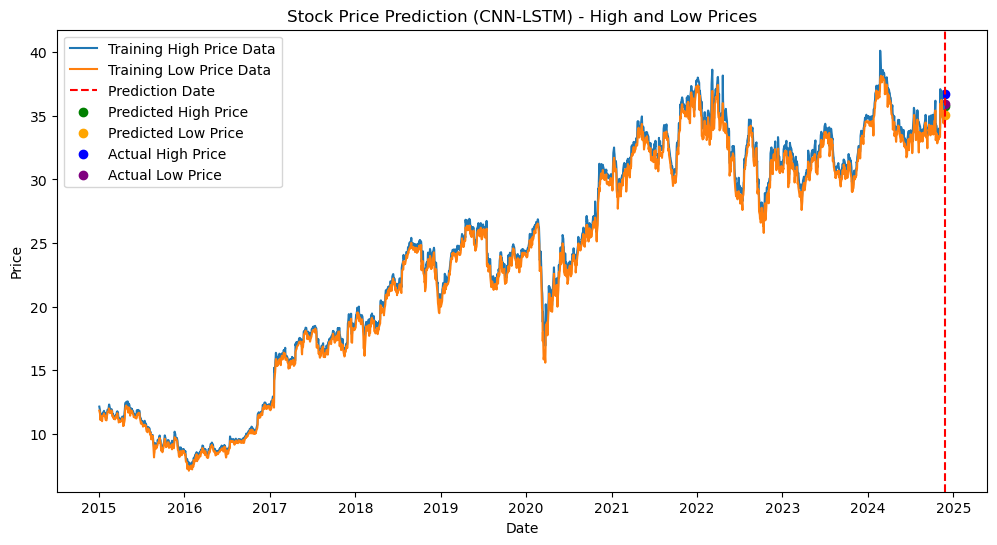

In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, MaxPooling1D
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Function to preprocess stock data
def preprocess_stock_data(file_path, stock_name):
    df = pd.read_csv(file_path)

    # Standardize stock names and input
    df['stockname'] = df['stockname'].str.strip().str.upper()
    stock_name = stock_name.strip().upper()

    # Filter data for the selected stock
    filtered_df = df[df['stockname'] == stock_name]
    if filtered_df.empty:
        raise ValueError(f"No data found for stock '{stock_name}'.")

    # Convert timestamp to date and sort
    filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'], errors='coerce').dt.date
    filtered_df = filtered_df.sort_values(by='timestamp')

    # Handle missing values
    numeric_cols = filtered_df.select_dtypes(include=['float64', 'int64']).columns
    imputer = SimpleImputer(strategy='mean')
    filtered_df[numeric_cols] = imputer.fit_transform(filtered_df[numeric_cols])

    # Add technical indicators
    filtered_df['moving_average'] = filtered_df['high'].rolling(window=5).mean()
    filtered_df['std_dev'] = filtered_df['high'].rolling(window=5).std()

    return filtered_df

# Prepare CNN-LSTM data
def prepare_cnn_lstm_data(df, lookback=60):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[['high', 'low']])  # Scaling both high and low prices
    
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i])  # Input sequence for CNN-LSTM
        y.append(scaled_data[i])  # Target high and low prices
    
    X, y = np.array(X), np.array(y)
    return X, y, scaler

# Build CNN-LSTM model
def create_cnn_lstm_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        LSTM(50, return_sequences=True),
        LSTM(50),
        Dense(25, activation='relu'),
        Dense(2)  # Output layer for both high and low prices
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Predict for a specific date
def find_exact_date(df, target_date):
    target_date = target_date.date()
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce').dt.date
    if target_date in df['timestamp'].values:
        return target_date
    else:
        raise ValueError(f"No data for the exact date {target_date}.")

if __name__ == "__main__":
    stock_name = input("Enter stock name (e.g., AAPL): ")
    data = preprocess_stock_data('stocks.csv', stock_name)

    prediction_date = input("Enter date for prediction (YYYY-MM-DD): ")
    prediction_date = pd.to_datetime(prediction_date)

    try:
        exact_date = find_exact_date(data, prediction_date)
        print(f"Using data up to the exact available date: {exact_date}.")
    except ValueError as e:
        print(e)
        exit()

    # Training and testing split
    train_data = data[data['timestamp'] < exact_date]
    test_data = data[data['timestamp'] == exact_date]
    if test_data.empty:
        raise ValueError(f"No data for prediction date: {exact_date}.")

    # Prepare data
    X_train, y_train, scaler = prepare_cnn_lstm_data(train_data, lookback=60)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 2))  # Input shape for CNN-LSTM

    # Train the model
    model = create_cnn_lstm_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

    # Prepare test data for prediction
    X_test, _, _ = prepare_cnn_lstm_data(pd.concat([train_data, test_data]), lookback=60)
    X_test = X_test[-1].reshape((1, X_test.shape[1], 2))

    # Predict and evaluate
    predicted_prices = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)  # Rescale predictions
    predicted_high_price, predicted_low_price = predicted_prices[0]

    actual_high_price = test_data['high'].values[0]
    actual_low_price = test_data['low'].values[0]
    mae_high = abs(predicted_high_price - actual_high_price)
    mae_low = abs(predicted_low_price - actual_low_price)

    print(f"\nPrediction Results:")
    print(f"Prediction Date: {exact_date}")
    print(f"Predicted High Price: {predicted_high_price:.2f}")
    print(f"Actual High Price: {actual_high_price:.2f}")
    print(f"Mean Absolute Error (MAE) for High Price: {mae_high:.2f}")
    print(f"Predicted Low Price: {predicted_low_price:.2f}")
    print(f"Actual Low Price: {actual_low_price:.2f}")
    print(f"Mean Absolute Error (MAE) for Low Price: {mae_low:.2f}")

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['timestamp'], train_data['high'], label="Training High Price Data")
    plt.plot(train_data['timestamp'], train_data['low'], label="Training Low Price Data")
    plt.axvline(x=exact_date, color='r', linestyle='--', label="Prediction Date")
    plt.scatter(exact_date, predicted_high_price, color='g', label="Predicted High Price")
    plt.scatter(exact_date, predicted_low_price, color='orange', label="Predicted Low Price")
    plt.scatter(exact_date, actual_high_price, color='blue', label="Actual High Price")
    plt.scatter(exact_date, actual_low_price, color='purple', label="Actual Low Price")
    plt.title("Stock Price Prediction (CNN-LSTM) - High and Low Prices")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()
